# Solving Fisher's Equation using FD Methods
We aim to solve [Fisher's equation](https://en.wikipedia.org/wiki/Fisher%27s_equation) using the theta-method, in particular a [Crank-Nicolson scheme](https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method). That is, find $u(x,t)$ such that
$$ \frac{\partial u}{\partial t} - D \frac{\partial^2 u}{\partial x^2} = ru(1-u).$$
for $x \in [0,L], t\in[0,T]$
Domain boundary conditions
Initial $u(x,0) = \mathbb{1}_{[0,L/10]}(x) $
Dirichlet boundary condition: $u(0,t) = 1, u(L,t) = 0$


In [1]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
sns.set(style="white", context="paper")

After we've imported all the packages we need, we must set the size of the domain and the discretisation mesh we wish to solve on.

In [2]:
L = 100
T_end = 50
r = 1
D = 1
# Theta method parameter, 0.5 corresponds to Crank-Nicolson scheme
theta = 0.5


# Space grid parameters
n_points = 401
dx = L / (n_points - 1)
x = np.arange(0, L + dx, dx)

dt = 0.01
discretised_time = np.arange(0,T_end + dt,dt)


# initial conditions
u_initial = np.zeros(n_points)
u_initial[ : (n_points // 10)] = 1
u = u_initial

# Set number of lines to plot
n_plot = 8

The last thing to do before solving the system is to create the tridiagonal matrix derived from discretising the spatial derivatives in the PDE. As the matrix is tridiagonal, using a sparse representation will help save computer memory and speed up computation time. This is provided by `scipy.sparse.diags`. See [the documentation for more info](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.diags.html#scipy.sparse.diags).

In [3]:
# For convenience, familiar from von Neumann stability analysis
mu = dt / dx ** 2

upper = -(theta * mu) * np.ones(n_points - 1)
main = (1 + 2 * theta * mu) * np.ones(n_points)
lower = -(theta * mu) * np.ones(n_points - 1)


diagonals = [lower, main, upper]
A = diags(diagonals, offsets=[-1, 0, 1], format="csr")
A[0, 0] = 1  # Dirichlet boundary  conditions
A[-1, -1] = 1

We are now ready to solve the PDE. We have created a matrix $A$ such that $Au^{n+1} = b$. All that remains is to calculate this vector $b$, which depends on $u^n$ and is here made up of the diffusion term, and the reaction term $ru(1-u)$.

In [4]:
# Create empty lists to store solution
u_store = []
time_store = [] 

for time_step in discretised_time:
    # Store solution if (T_end/n_plot) time has elapsed
    # It will store initial condition on the first iteration
    if time_step % (T_end/n_plot) == 0:
        u_store.append(u)
        time_store.append(time_step)
    # Update reaction term and diffusion
    u_kinetics = r * u * (1 - u) * dt
    u_diffusion = mu * (1 - theta) * D *(np.roll(u, -1) - 2 * u + np.roll(u, 1))
    
    b = u + u_diffusion + u_kinetics
    b[0] = 1
    b[-1] = 0  # enforce Dirichlet boundary conditions
    # Solve the linear system Au = b
    # this overwrites our previous timestep
    u = spsolve(A, b)

We have now calculated the solution up until `T_end` and stored it at `n_plot` evenly spaced time points. These time points are stored in the list `time_store`, and the solution is in `u_store`. All that remains is to plot it.

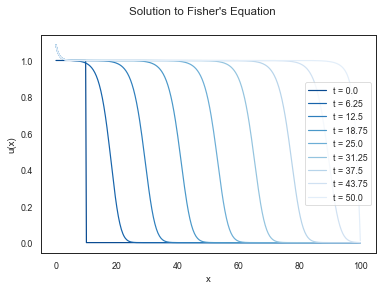

In [7]:
fig, ax = plt.subplots()
sns.set_palette("Blues_r", n_colors=n_plot+1)

ax.plot(x, np.array(u_store).T)
    
ax.set(xlabel="x", ylabel="u(x)")
ax.legend(labels=[f"t = {i}" for i in time_store], loc="right")
fig.suptitle("Solution to Fisher's Equation")
plt.show()